# From the github repo

In [553]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
from time import sleep

# Linien imports
from linien_client.device import Device
from linien_client.connection import LinienClient
from linien_common.common import AutolockMode
from linien_common.common import  MHz, Vpp, ANALOG_OUT_V

# --------------------------------------------------------------------
# Matplotlib Inline Patch — fixes AttributeError on rcParams._get
# --------------------------------------------------------------------
import matplotlib as mpl
if not hasattr(mpl.rcParams, "_get"):
    mpl.rcParams._get = mpl.rcParams.get
# --------------------------------------------------------------------

#import matplotlib
#matplotlib.use("TkAgg")  # or "Qt5Agg"

# ----------------------------------------------
# Connection setup
# ----------------------------------------------
dev = Device(
    host="192.168.1.159",  # IP address of your Red Pitaya
    username="root",
    password="root"
)

c = LinienClient(dev)
c.connect(autostart_server=True, use_parameter_cache=True)

# Choose autolock algorithm:
#   AutolockMode.SIMPLE  -> CPU-based, faster but less robust
#   AutolockMode.ROBUST  -> FPGA-based, slower startup but stable
c.parameters.autolock_mode_preference.value = AutolockMode.ROBUST
sleep(1)  # optional short delay to ensure the setting is applied

# ----------------------------------------------
# Helper: wait until laser is locked/unlocked
# ----------------------------------------------
def wait_for_lock_status(should_be_locked):
    """Wait until the laser reaches the desired lock state."""
    counter = 0
    while True:
        print("checking lock status...")
        to_plot = pickle.loads(c.parameters.to_plot.value)

        print(f"to_plot keys: {list(to_plot.keys())}")

        is_locked = "error_signal" in to_plot

        if is_locked == should_be_locked:
            break

        counter += 1
        if counter > 10:
            raise Exception("waited too long")

        sleep(1)


# ----------------------------------------------
# Main autolock procedure
# ----------------------------------------------

# Turn off the lock (if currently running)
c.connection.root.start_sweep()
c.parameters.modulation_frequency.value = 0.05*MHz
c.parameters.modulation_amplitude.value = 0.5*Vpp
c.parameters.p.value = 5000
c.parameters.i.value = 100
c.parameters.d.value = 0
c.parameters.target_slope_rising.value = True
c.parameters.control_signal_history_length.value = 2000

#c.parameters.pid_on_slow_enabled.value = False

c.connection.root.write_registers()

linien_client.connection       INFO     Try to connect to 192.168.1.159:18862
linien_client.connection       DEBUG    Sent authentication hash
linien_client.connection       INFO     Connection established!


In [147]:
c.parameters.demodulation_phase_a.value = 160
c.connection.root.write_registers()

In [179]:
c.parameters.filter_1_frequency_a.value = 8000
c.parameters.filter_2_frequency_a.value = 4000
c.connection.root.write_registers()

In [431]:
c.parameters.check_for_changed_parameters()

mod_freq_raw = c.parameters.modulation_frequency.value
mod_freq = mod_freq_raw/MHz
print(f"Modulation frequency: {mod_freq} MHz")

mod_ampl_raw = c.parameters.modulation_amplitude.value
mod_ampl = mod_ampl_raw/Vpp
print(f"Modulation amplitude: {mod_ampl} Vpp")

demod_phase = c.parameters.demodulation_phase_a.value
print(f"Demodulation phase: {demod_phase} degrees")

demod_filter_1 = c.parameters.filter_1_frequency_a.value
print(f"Demodulation filter 1: {demod_filter_1} Hz")

demod_filter_2 = c.parameters.filter_2_frequency_a.value
print(f"Demodulation filter 2: {demod_filter_2} Hz")

Modulation frequency: 0.05 MHz
Modulation amplitude: 0.5 Vpp
Demodulation phase: 150.0 degrees
Demodulation filter 1: 10000.0 Hz
Demodulation filter 2: 10000.0 Hz


In [554]:
c.parameters.offset_a.value = -85
c.connection.root.write_registers()

In [387]:
c.parameters.check_for_changed_parameters()
print("offset_a set to :", c.parameters.offset_a.value)

offset_a set to : 0


checking lock status...
to_plot keys: ['error_signal_1', 'monitor_signal', 'slow_control_signal']
dict_keys(['error_signal_1', 'monitor_signal', 'slow_control_signal'])


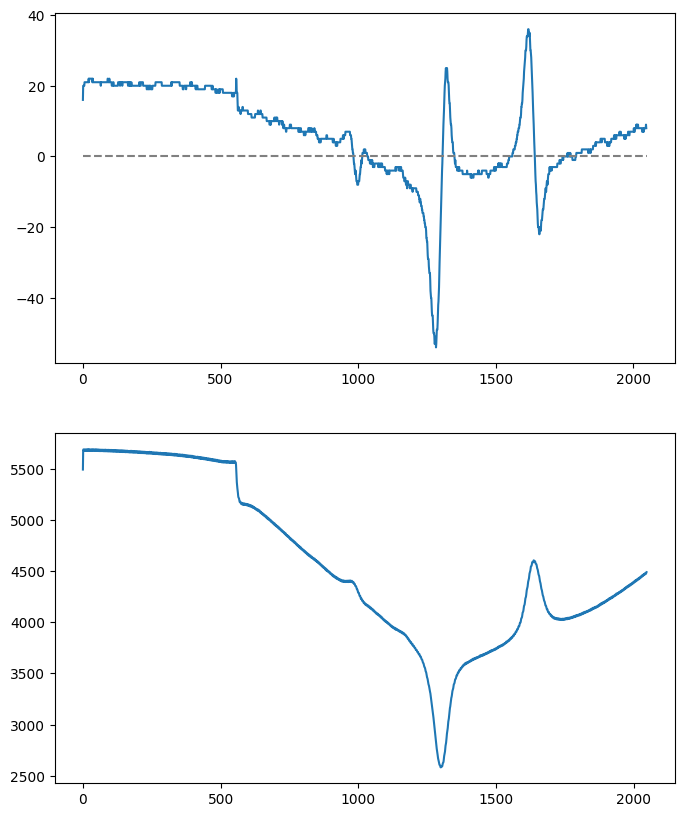

In [555]:

# Wait until the laser is unlocked
wait_for_lock_status(False)

# Record a reference spectrum
to_plot = pickle.loads(c.parameters.to_plot.value)

print(to_plot.keys())

fig,ax = plt.subplots(2,1, figsize=(8, 10))
ax[0].plot(to_plot["error_signal_1"], label="error_signal_1")
ax[0].hlines(0, 0, len(to_plot["error_signal_1"]), color='gray', linestyle='--')
#ax[0].set_ylim(-150,150)
ax[1].plot(to_plot["monitor_signal"], label="monitor_signal_1")

checking lock status...
to_plot keys: ['error_signal_1', 'monitor_signal', 'slow_control_signal']


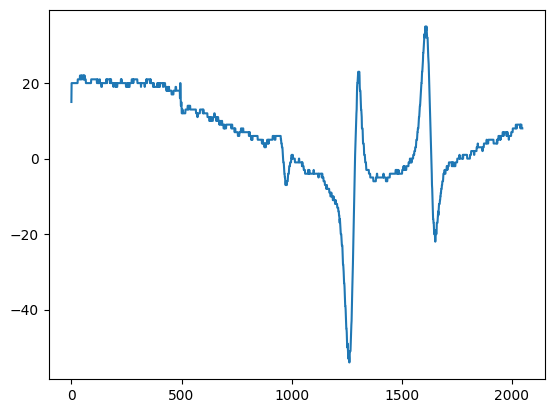

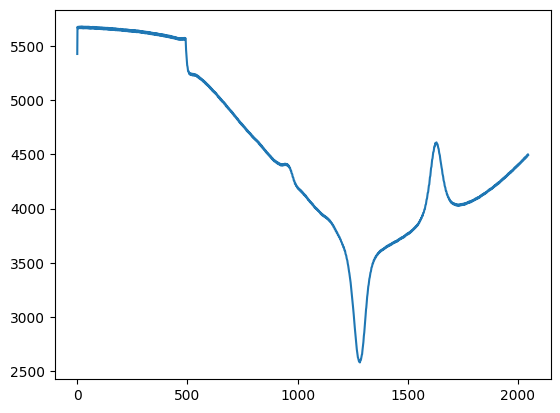

Please specify the position of the target line.


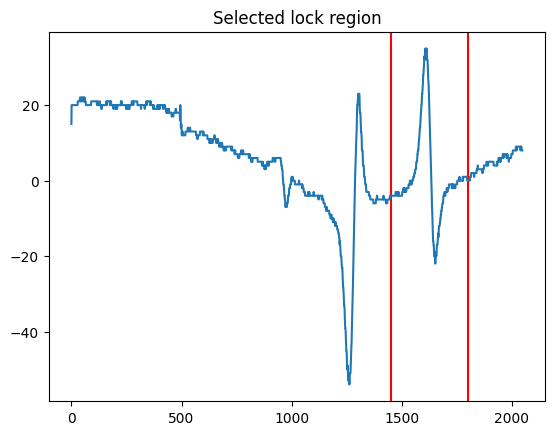

Selected region: 1450–1800 of 2048 points
checking lock status...
to_plot keys: ['error_signal_1', 'monitor_signal', 'slow_control_signal']
checking lock status...
to_plot keys: ['error_signal_1', 'monitor_signal', 'slow_control_signal']
checking lock status...
to_plot keys: ['error_signal_1', 'monitor_signal', 'slow_control_signal']
checking lock status...
to_plot keys: ['error_signal_1', 'monitor_signal', 'slow_control_signal']
checking lock status...
to_plot keys: ['error_signal', 'control_signal', 'monitor_signal', 'slow_control_signal']
Locking the laser worked! \o/


In [556]:

# Wait until the laser is unlocked
wait_for_lock_status(False)

# Record a reference spectrum
to_plot = pickle.loads(c.parameters.to_plot.value)
error_signal = to_plot["error_signal_1"]

# Plot the reference and monitor signals with two y-axes
plt.plot(error_signal)
plt.show()
plt.plot(to_plot["monitor_signal"])
plt.show()

# Ask user for target line region
print("Please specify the position of the target line.")
x0 = int(input("Enter index of a point on the LEFT side of the target line: "))
x1 = int(input("Enter index of a point on the RIGHT side of the target line: "))

# Visualize selected lock region
plt.axvline(x0, color="r")
plt.axvline(x1, color="r")
plt.plot(error_signal)
plt.title("Selected lock region")
plt.show()

# Start autolock with selected region

signal_len = len(error_signal)
print(f"Selected region: {x0}–{x1} of {signal_len} points")

if not (0 <= x0 < x1 <= signal_len):
    raise ValueError("Invalid region: indices outside range or reversed")

if x1 - x0 < 10:
    raise ValueError("Selected region too narrow — pick a wider range")

#sleep(2)

c.connection.root.start_autolock(x0, x1, pickle.dumps(error_signal))

# Wait until laser is actually locked
max_tries = 3
i = 0
try:
    wait_for_lock_status(True)
    print("Locking the laser worked! \\o/")
except Exception:
    #if i < max_tries:
        #i += 1
        #print("Locking the laser failed :(, trying again...")
        #c.connection.root.start_autolock(x0, x1, pickle.dumps(error_signal))
    #else:
    print("Locking the laser failed :(, no more tries left.") #to indent
    c.connection.root.start_sweep() #to indent

In [479]:
c.connection.root.start_sweep()

In [409]:
c.parameters.p.value = 5000
c.parameters.i.value = 100
c.parameters.d.value = 0
c.parameters.target_slope_rising.value = True

#c.parameters.pid_on_slow_enabled.value = False

c.connection.root.write_registers()

In [371]:
c.parameters.check_for_changed_parameters()

print(c.parameters.p.value)
print(c.parameters.i.value)
print(c.parameters.d.value)

print(c.parameters.target_slope_rising.value)
print(c.parameters.pid_on_slow_enabled.value)

5000
100
0
True
True


In [253]:
print(c.parameters.__dict__.keys())

dict_keys(['remote', 'uuid', '_async_changed_parameters_queue', '_async_listener_registering', '_listeners_pending_remote_registration', '_callbacks', 'to_plot', 'signal_stats', 'mod_channel', 'sweep_channel', 'control_channel', 'slow_control_channel', 'gpio_p_out', 'gpio_n_out', 'analog_out_1', 'analog_out_2', 'analog_out_3', 'lock', 'polarity_fast_out1', 'polarity_fast_out2', 'polarity_analog_out0', 'control_signal_history_length', 'control_signal_history', 'monitor_signal_history', 'pause_acquisition', 'fetch_additional_signals', 'ping', 'sweep_amplitude', 'sweep_center', 'sweep_speed', 'sweep_pause', 'modulation_amplitude', 'modulation_frequency', 'pid_only_mode', 'dual_channel', 'channel_mixing', 'demodulation_phase_a', 'demodulation_phase_b', 'demodulation_multiplier_a', 'demodulation_multiplier_b', 'offset_a', 'offset_b', 'invert_a', 'invert_b', 'filter_automatic_a', 'filter_automatic_b', 'filter_1_enabled_a', 'filter_2_enabled_a', 'filter_1_enabled_b', 'filter_2_enabled_b', 'fi

In [437]:
c.parameters.check_for_changed_parameters()
print(c.parameters.signal_stats.value)

{'error_signal_mean': 20.50146484375, 'error_signal_std': 0.49999785422818377, 'error_signal_max': 21, 'error_signal_min': 20, 'control_signal_mean': 8191.0, 'control_signal_std': 0.0, 'control_signal_max': 8191, 'control_signal_min': 8191, 'monitor_signal_mean': 5308.04150390625, 'monitor_signal_std': 27.529099236435542, 'monitor_signal_max': 5358, 'monitor_signal_min': 5262, 'slow_control_signal_mean': -4313.0, 'slow_control_signal_std': 0.0, 'slow_control_signal_max': -4313, 'slow_control_signal_min': -4313}


Signals monitor

In [ ]:

print(c.parameters.control_signal_history.value)
print(len(c.parameters.control_signal_history.value))

<class 'dict'>
4


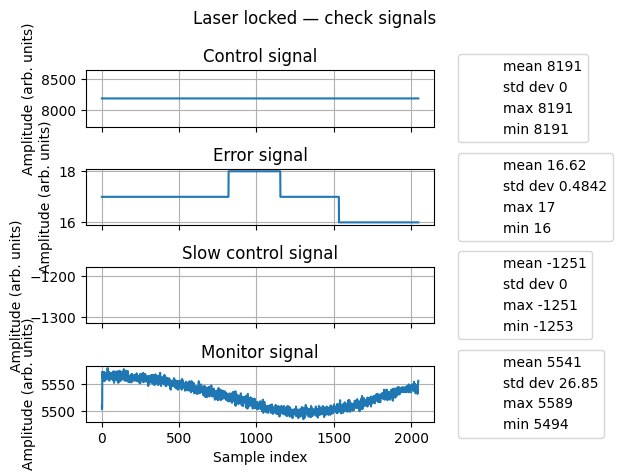

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

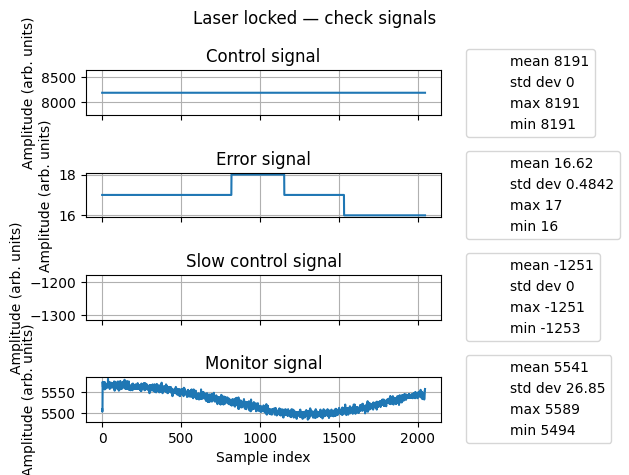

In [559]:
from IPython import display

counter = 0
limit = 5

c.parameters.check_for_changed_parameters()

while True:

    if counter >= limit:
        break

    counter +=1

    # Fetch the most recent data again after locking
    plot_data = pickle.loads(c.parameters.to_plot.value)
    #print(plot_data.keys())

    display.clear_output(wait=True)
    plt.clf()

    if c.parameters.lock.value:
        fig, ax = plt.subplots(4, 1, sharex=True, tight_layout=True)
        fig.suptitle("Laser locked — check signals")

        ax[0].set_title("Control signal")
        ax[0].plot(plot_data["control_signal"])
        ax[0].plot([], [], label = f"mean {c.parameters.signal_stats.value['control_signal_mean']:.4g}", linestyle='none')
        ax[0].plot([], [], label = f"std dev {c.parameters.signal_stats.value['control_signal_std']:.4g}", linestyle='none')
        ax[0].plot([], [], label = f"max {c.parameters.signal_stats.value['control_signal_max']:.4g}", linestyle='none')
        ax[0].plot([], [], label = f"min {c.parameters.signal_stats.value['control_signal_min']:.4g}", linestyle='none')
        
        ax[1].set_title("Error signal")
        ax[1].plot(plot_data["error_signal"])
        ax[1].plot([], [], label = f"mean {c.parameters.signal_stats.value['error_signal_mean']:.4g}", linestyle='none')
        ax[1].plot([], [], label = f"std dev {c.parameters.signal_stats.value['error_signal_std']:.4g}", linestyle='none')
        ax[1].plot([], [], label = f"max {c.parameters.signal_stats.value['error_signal_max']:.4g}", linestyle='none')
        ax[1].plot([], [], label = f"min {c.parameters.signal_stats.value['error_signal_min']:.4g}", linestyle='none')

        ax[2].set_title("Slow control signal")
        ax[2].plot(plot_data["slow_control_signal"])
        ax[2].plot([], [], label = f"mean {c.parameters.signal_stats.value['slow_control_signal_mean']:.4g}", linestyle='none')
        ax[2].plot([], [], label = f"std dev {c.parameters.signal_stats.value['slow_control_signal_std']:.4g}", linestyle='none')
        ax[2].plot([], [], label = f"max {c.parameters.signal_stats.value['slow_control_signal_max']:.4g}", linestyle='none')
        ax[2].plot([], [], label = f"min {c.parameters.signal_stats.value['slow_control_signal_min']:.4g}", linestyle='none')


        # Optional: plot the monitor signal if available
        if "monitor_signal" in plot_data:
            ax[3].set_title("Monitor signal")
            ax[3].plot(plot_data["monitor_signal"])
            ax[3].plot([], [], label = f"mean {c.parameters.signal_stats.value['monitor_signal_mean']:.4g}", linestyle='none')
            ax[3].plot([], [], label = f"std dev {c.parameters.signal_stats.value['monitor_signal_std']:.4g}", linestyle='none')
            ax[3].plot([], [], label = f"max {c.parameters.signal_stats.value['monitor_signal_max']:.4g}", linestyle='none')
            ax[3].plot([], [], label = f"min {c.parameters.signal_stats.value['monitor_signal_min']:.4g}", linestyle='none')

    else:
        fig, ax = plt.subplots(2, 1, sharex=True, tight_layout=True)
        fig.suptitle("Laser sweeping/unlocked")
        ax[0].set_title("Error signal")
        ax[0].plot(plot_data["error_signal_1"])
        #plt.plot(plot_data["error_signal_2"], label="Error signal ch2")

        # Again, include monitor signal if present
        if "monitor_signal" in plot_data:
            ax[1].set_title("Monitor signal")
            ax[1].plot(plot_data["monitor_signal"])

    for i in range(len(ax)):
        ax[i].grid(True)
        ax[i].legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
        ax[i].set_ylabel('Amplitude (arb. units)')
    
    plt.xlabel('Sample index')
    display.display(plt.gcf())

    sleep(0.5)

Histories

dict_keys(['times', 'values', 'slow_values', 'slow_times'])
2000
1764081190.8375053


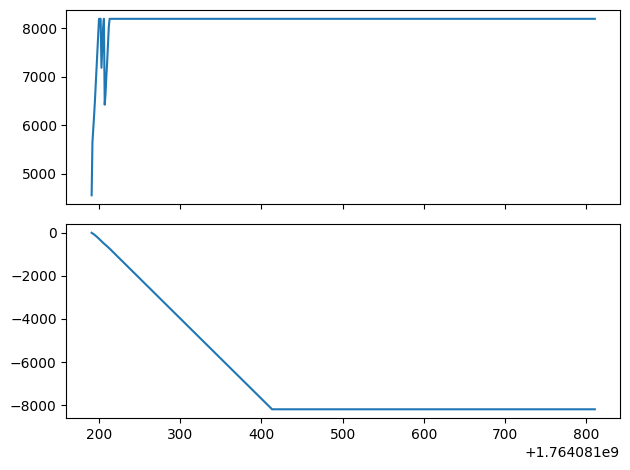

In [573]:
counter = 0
limit = 5

c.parameters.check_for_changed_parameters()

while True:

    if counter >= limit:
        break

    counter +=1

    control_history = c.parameters.control_signal_history.value
    signal_history = c.parameters.monitor_signal_history.value

    fig, axs = plt.subplots(3,1, sharex=True, tight_layout=True)
    fig.suptitle("Histories")

    ax0, ax1, ax2 = axs

    ax0.set_title("Control Signal")
    ax0.plot(control_history["times"], control_history["values"])

    ax1.set_title("Slow Control Signal")
    ax1.plot(control_history["slow_times"], control_history["slow_values"])



    sleep(1)


ch = c.parameters.control_signal_history.value
print(ch.keys())
print(c.parameters.control_signal_history_length.value)
print(c.parameters.control_signal_history.value["times"][0])

fig, axs = plt.subplots(2,1, sharex=True, tight_layout=True)
ax0, ax1 = axs
ax0.plot(ch["times"], ch["values"], label="Control Signal")
ax1.plot(ch["slow_times"], ch["slow_values"], label="Control Signal")

dict_keys(['times', 'values'])
1764081190.8387659


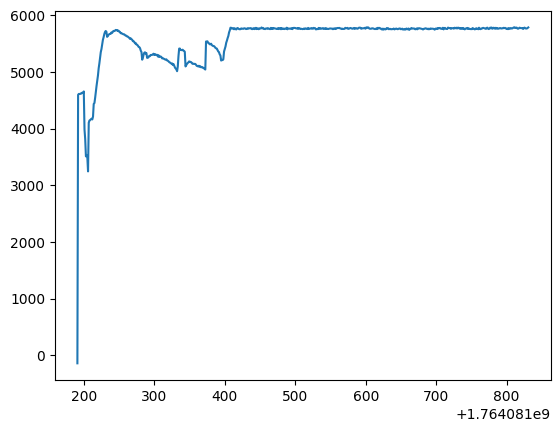

In [574]:
c.parameters.check_for_changed_parameters()

sh = c.parameters.monitor_signal_history.value
print(sh.keys())
print(c.parameters.monitor_signal_history.value["times"][0])

plt.plot(sh["times"], sh["values"], label="Monitor Signal")